# Sentiment Analysis of Edgar Company Filings

- Cohen, Malloy and Nguyen (2020), Loughran and McDonald (2011), and others
- sklearn, nltk, SEC Edgar, Wharton Research Data Services

Terence Lim

In [1]:
import re
import os
import requests
import time
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import sklearn.feature_extraction
from sklearn.metrics.pairwise import cosine_similarity
from nltk.tokenize import RegexpTokenizer
from tqdm import tqdm
from finds.database import SQL, MongoDB, Redis
from finds.structured import CRSP, Signals
from finds.busday import BusDay
from finds.unstructured import Unstructured
from finds.readers import fetch_lm
from finds.solve import weighted_average, fractiles
from finds.edgar import EdgarClone
from settings import settings
ECHO = False
sql = SQL(**settings['sql'])
user = SQL(**settings['user'])
bd = BusDay(sql)
rdb = Redis(**settings['redis'])
crsp = CRSP(sql, bd, rdb)
ed = EdgarClone(settings['10X'], zipped=True, echo=ECHO)
signals = Signals(user)
mongodb = MongoDB(**settings['mongodb'])
wordlists = Unstructured(mongodb, 'WordLists')
imgdir = os.path.join(settings['images'], 'edgar')
item, form = 'mda10K', '10-K'

## Load Loughran and MacDonald sentiment words and stopwords

In [2]:
mongodb = MongoDB()
wordlists = Unstructured(mongodb, 'WordLists')
sentiments = {k : wordlists['lm', k] for k in ['positive', 'negative']}

## Pre-process with sklearn

In [3]:
tf_vectorizer = sklearn.feature_extraction.text.CountVectorizer(
    strip_accents='unicode',
    lowercase=True,
    #stop_words=stop_words,
    # tokenizer=CustomTokenizer(),
    token_pattern=r"\b[^\d\W][^\d\W][^\d\W]+\b")
tokenize = tf_vectorizer.build_tokenizer()
analyze = tf_vectorizer.build_analyzer()

## Construct sentiment feature all years for usual universe


In [4]:
univs = {yr + 1: crsp.get_universe(bd.endmo(yr*10000 + 1231)).assign(year=yr + 1)
         for yr in range(1992, 2020)}
results = []
files = ed.open(form=form, item=item)  # open mda10K archive
tic = time.time()
permnos = files['permno'].unique().astype(int)
for i, permno in tqdm(enumerate(permnos)):  # Loop over all permnos
    
    # retrieve all valid mda's for this permno by year
    mdas = {}
    dates = {}
    for _, f in files[files['permno'].eq(permno)].iterrows():
        year = int(f['date']) // 10000
        if ((f['date'] // 100) % 100) <= 3:  # if filing date <= Mar
            year = year - 1                  # then assign to previous year
        if (year in univs and
            (year not in mdas or f['date'] < dates[year])): # and f['form']==form
            tokens = Series(analyze(ed[f['pathname']]), dtype='object')
            if len(tokens):
                mdas[year] = tokens
                dates[year] = f['date']

    # compute sentiment (count frequency) scores for permno by year
    sentiment = {year: (mda.isin(sentiments['positive']).sum() -
                        mda.isin(sentiments['negative']).sum()) / len(mda)
                 for year, mda in mdas.items()}  # compute sentiment by year

    # derive sentiment change and similarity scores by year
    for year in sorted(mdas.keys()):
        result = {'year': year, 'permno': permno, 'date': dates[year]}
        result['mdasent'] = sentiment[year]
        result['currlen'] = len(mdas[year])
        if year-1 in mdas:
            result['prevlen'] = len(mdas[year-1])
            result['mdachg'] = sentiment[year] - sentiment[year-1]
            
            corpus = [" ".join(mdas[year]), " ".join(mdas[year-1])]
            cos = cosine_similarity(tf_vectorizer.fit_transform(corpus))
            result['mdacos'] = cos[0, 1]
        if ECHO:
            print(i, int(time.time()-tic), result)
        results.append(result)

# save in signals database
data = DataFrame.from_records(results)
data['rebaldate'] = bd.offset(data['date'])
print(signals.write(data, 'mdasent', overwrite=True),
      signals.write(data, 'mdachg', overwrite=True),
      signals.write(data, 'mdacos', overwrite=True))

# right join data with univ, to identify univ with missing mda
data = pd.concat([data[data['year']==year]\
                  .drop(columns=['year'])\
                  .set_index('permno')\
                  .join(univ[['year']], how='right')\
                  .reset_index()
                  for year, univ in univs.items() if year <= 2020],
                 ignore_index=True)


12632it [49:18,  4.27it/s]


107105 88292 88292


In [4]:
# save sentiment dataframe in scratch folder
from settings import pickle_load, pickle_dump
#pickle_dump(data, 'sentiment.data')
data = pickle_load('sentiment.data')
data

,permno,date,mdasent,currlen,prevlen,mdachg,mdacos,rebaldate,year
0,10001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1993
1,10002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1993
2,10003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1993
3,10009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1993
4,10010,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1993
...,...,...,...,...,...,...,...,...,...
140887,93422,20210224.0,-0.016102,9067.0,9282.0,0.004906,0.991380,20210224.0,2020
140888,93423,20210225.0,-0.014817,6749.0,5599.0,-0.001958,0.988981,20210225.0,2020
140889,93426,20210311.0,-0.008874,6874.0,8297.0,-0.000437,0.991599,20210311.0,2020
140890,93434,20200923.0,-0.008918,7737.0,6412.0,-0.001276,0.991236,20200923.0,2020


## Display sentiment of extreme documents
- "collaborat*" was oft-used word associated with positive sentiment

77973 20210331
15856 20210225


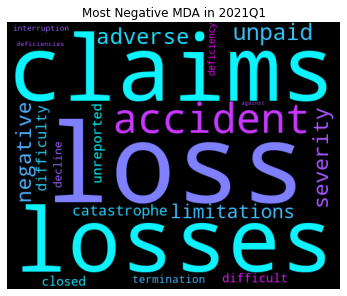

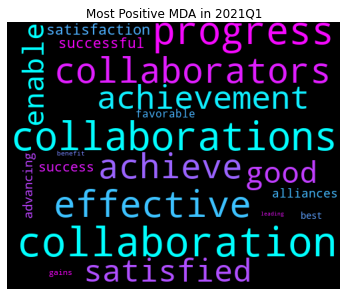

In [10]:
top_n = 20
files = ed.open(form=form, item=item)
docs = data[data['date'].between(20210101, 20210331)].sort_values('mdasent')
for ifig, (iloc, sense) in enumerate({0: 'negative', -1: 'positive'}.items()):
    permno, date = int(docs.iloc[iloc]['permno']), int(docs.iloc[iloc]['date'])
    print(permno, date)
    doc = ed[files[files['permno'].eq(permno) & files['date'].eq(date)].iloc[0]]
    tokens = analyze(doc)
    words = Series([t for t in tokens if t in sentiments[sense]]).value_counts()
    words.iloc[:] = 0
    words.iloc[:top_n] = np.arange(top_n, 0, -1)
    wc = WordCloud(width=500, height=400, colormap='cool') 
    fig, ax = plt.subplots(num=1+ifig, clear=True, figsize=(5, 4))
    ax.imshow(wc.generate_from_frequencies(words.iloc[:top_n].to_dict()))
    ax.axis("off")
    plt.tight_layout()
    ax.set_title(f"Most {sense.capitalize()} MDA in 2021Q1")
    plt.savefig(os.path.join(imgdir, f"{sense}.jpg"))
plt.show()

## Stacked Bar Plot of universe coverage by year


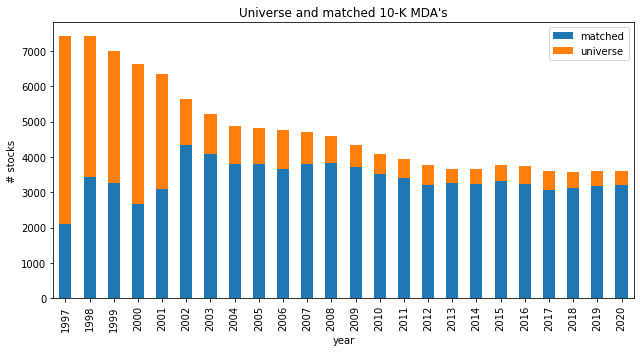

In [23]:
y1 = data[data['mdasent'].notna()].groupby('year')['permno'].count()
y0 = data[data['mdasent'].isna()].groupby('year')['permno'].count()\
                                                           .reindex(y1.index)
fig, ax = plt.subplots(1, 1, clear=True, num=1, figsize=(9, 5))
y1.plot(kind='bar', label='matched', color='C0', ax=ax, rot=90)
y0.plot(kind='bar', label='universe', color='C1', ax=ax, rot=90, bottom=y1)
ax.set_ylabel('# stocks')
ax.set_title("Universe and matched 10-K MDA's")
ax.legend()
plt.tight_layout()
plt.savefig(os.path.join(imgdir, 'coverage.jpg'))
plt.show()

## Stacked Bar Plot of filings by month, by day-of-week

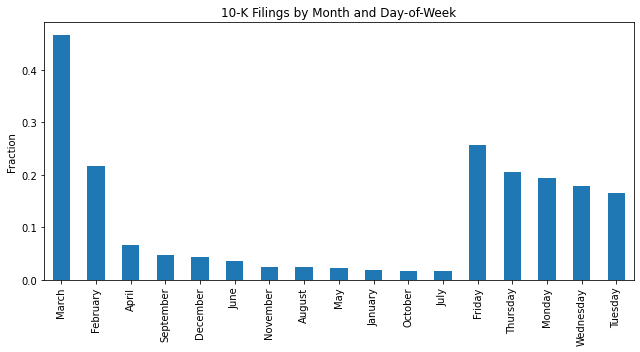

In [24]:
y = DataFrame.from_records([{'date': d, 'day': bd(d).strftime('%A'),
                             'month': bd(d).strftime('%B')}
                            for d in data.loc[data['mdasent'].notna(), 'date']])
z = (y['month'].value_counts()/len(y)).append(y['day'].value_counts()/len(y))
fig, ax = plt.subplots(1, 1, clear=True, num=1, figsize=(9, 5))
z.plot(kind='bar', color='C0', ax=ax, rot=90)
ax.set_ylabel('Fraction')
ax.set_title("10-K Filings by Month and Day-of-Week")
plt.tight_layout()
plt.savefig(os.path.join(imgdir, 'calendar.jpg'))
plt.show()

## Plot of average sentiment, change, cosine similarity by year
- visualize with economy-wide profitabality (CP Corporate Profits from FRED)

### Align year as caldate, e.g. for caldate year 2019:
- filings from April 2019 to Mar 2020 (i.e. year = filing year-1 if month<=3)
- universe is as of year end prior to filing date
- economic time series is average annual value ending Dec 2019
- concurrent return year is Jan 2019 to Dec 2019
- next return year (i.e. lagged filings) is April 2020-Mar 2021


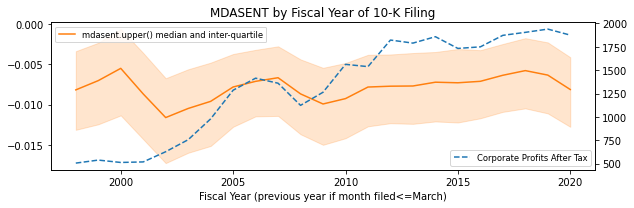

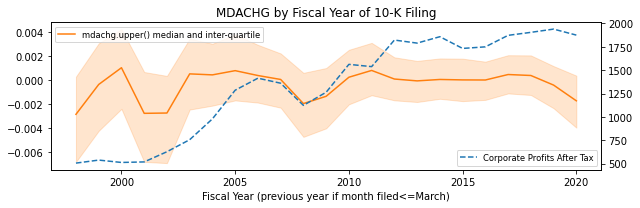

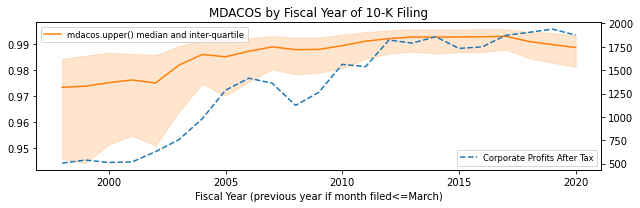

In [25]:
from finds.alfred import Alfred
al = Alfred(api_key=settings['fred']['api_key'])
series_id = 'CP'  # Corporate Profits
#series_id = 'UNRATE'
#series_id = 'WILL5000IND'
econ = al(series_id)
econ = econ.to_frame().assign(year=econ.index // 10000).groupby('year').mean()

for i, sent in enumerate(['mdasent', 'mdachg', 'mdacos']):
    g = data[data['currlen'].gt(500)].dropna().groupby('year')
    iq1, iq2, iq3 = [g[sent].quantile(p) for p in [.25, .5, .75]]
    y = iq2.index.astype(int)
    fig, ax = plt.subplots(1, 1, clear=True, num=1+i, figsize=(9, 3))
    ax.plot(y, iq2, ls='-', color='C1')
    ax.fill_between(y, iq1, iq3, alpha=0.2, color='C1')
    ax.set_title(f"{sent.upper()} by Fiscal Year of 10-K Filing")
    ax.set_xlabel("Fiscal Year (previous year if month filed<=March)")
    ax.legend([f"{sent}.upper() median and inter-quartile"], fontsize='small',
              loc='upper left')
    #econ.index = ax.get_xticks()   # boxplot(by) has sequential xticks
    bx = ax.twinx()
    econ[(econ.index >= min(y)) & (econ.index<=max(y))].plot(ls='--', ax=bx)
    bx.legend([al.header(series_id)[:27]],fontsize='small', loc='lower right')
    plt.tight_layout()
    plt.savefig(os.path.join(imgdir, f'{sent}.jpg'))
plt.show()

## Quintile cap-weighted spread portfolio returns
- same year filings [yr]0101:[yr]1231 = bd.begyr(caldate) to caldate
- lagged [yr+1]0401:[yr+2]0331 = bd.begmo(caldate,4) - bd.endmo(caldate,15)

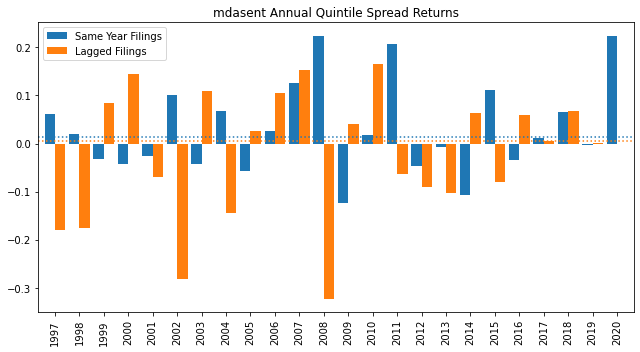

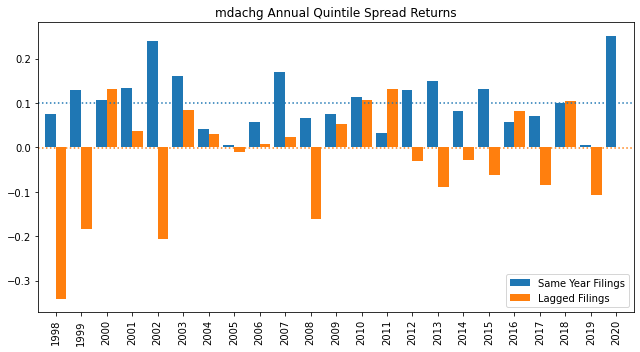

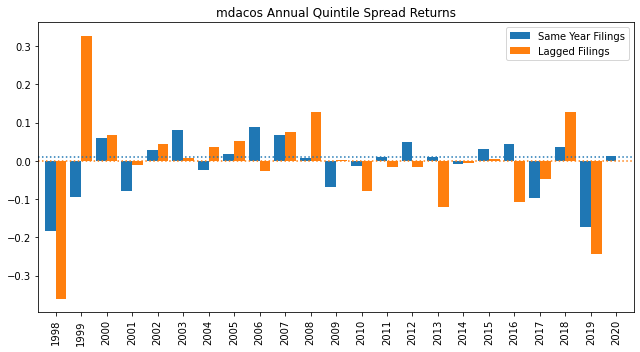

In [26]:
for ifig, key in enumerate(['mdasent', 'mdachg', 'mdacos']):
    ret1 = {}   # to collect year-ahead spread returns
    ret0 = {}   # to collect current-year spread returns
    for year in sorted(np.unique(data['year'])):  # loop over years
        
        # compute current year spread returns
        beg = bd.begyr(year)
        end = bd.endyr(year)
        univ = data[data['year'] == year]\
                   .dropna(subset=[key])\
                   .set_index('permno')\
                   .join(crsp.get_cap(bd.offset(beg, -1)), how='inner')\
                   .join(crsp.get_ret(beg, end, delist=True), how='left')
        if len(univ):
            sub = fractiles(univ[key], [20, 80])
            pos = weighted_average(univ.loc[sub==1,['cap','ret']],'cap')['ret']
            neg = weighted_average(univ.loc[sub==3,['cap','ret']],'cap')['ret']
            ret0[end] = {'ret':pos-neg, 'npos':sum(sub==1), 'nneg':sum(sub==3)}
            if ECHO:
                print(end, len(univ), pos, neg)
            
        # compute year ahead spread returns
        beg = bd.begmo(end, 4)
        end = bd.endmo(end, 15)
        univ = data[data['year'] == year]\
                   .dropna(subset=[key])\
                   .set_index('permno')\
                   .join(crsp.get_cap(bd.offset(beg, -1)), how='inner')\
                   .join(crsp.get_ret(beg, end, delist=True), how='left')
        if len(univ):
            sub = fractiles(univ[key], [20, 80])
            pos = weighted_average(univ.loc[sub==1,['cap','ret']],'cap')['ret']
            neg = weighted_average(univ.loc[sub==3,['cap','ret']],'cap')['ret']
            ret1[end] = {'ret':pos-neg, 'npos':sum(sub==1), 'nneg':sum(sub==3)}
            if ECHO:
                print(end, len(univ), pos, neg)

    r0 = DataFrame.from_dict(ret0, orient='index').sort_index()
    r0.index = r0.index // 10000
    r1 = DataFrame.from_dict(ret1, orient='index').sort_index()
    r1.index = (r1.index // 10000) - 2

    fig, ax = plt.subplots(1, 1, clear=True, num=1+ifig, figsize=(9, 5))
    pd.concat([r0['ret'].rename('Same Year Filings').to_frame(),
               r1['ret'].rename('Lagged Filings').to_frame()],
              join='outer', axis=1).plot(kind='bar',ax=ax, width=.85)
    ax.set_title(f"{key} Annual Quintile Spread Returns")
    ax.axhline(r0['ret'].median(), linestyle=':', color='C0')
    ax.axhline(r1['ret'].median(), linestyle=':', color='C1')
    plt.tight_layout()
    plt.savefig(os.path.join(imgdir, f'{key}RET.jpg'))
plt.show()